# PaddleHub 人脸相关模型实践

# 一、前言
随着AI技术的发展，越来越多的人脸技术被应用到了我们生活中的方方面面，**刷脸支付、刷脸闸机通行、酒店人脸比对**等场景都是人脸技术的应用 ，对人们的生活已经产生了巨大的影响。而在这些技术当中，人脸检测、人脸关键点定位是人脸应用中的关键步骤，它是诸如自动人脸识别、表情分析、三维人脸重建及三维动画等其它人脸相关问题的前提和突破口。

本文主要基于PaddleHub官方教程，尝试其近期发布的人脸相关模型：

1. 人脸检测模型：Ultra-Light-Fast-Generic-Face-Detector-1MB(适用于轻量移动端)的[ultra_light_fast_generic_face_detector_1mb_320](https://www.paddlepaddle.org.cn/hubdetail?name=ultra_light_fast_generic_face_detector_1mb_320&en_category=ObjectDetection)或者[ultra_light_fast_generic_face_detector_1mb_640](https://www.paddlepaddle.org.cn/hubdetail?name=ultra_light_fast_generic_face_detector_1mb_640&en_category=ObjectDetection)

2. 关键点检测模型[face_landmark_localization](https://www.paddlepaddle.org.cn/hubdetail?name=face_landmark_localization&en_category=KeyPointDetection)，该模型转换自 [https://github.com/lsy17096535/face-landmark](https://github.com/lsy17096535/face-landmark) ，支持同一张图中的多个人脸检测。它可以识别人脸中的68个关键点。

<p align="center">
<img src="https://paddlehub.bj.bcebos.com/resources/face_landmark.jpg"  hspace='5' width=500/> <br />
</p>

在本教程中，我们将展示如何使用人脸关键点检测模型进行将人脸的嘴部换到了猫脸上，实现了抖音猫脸人嘴特效。

**NOTE：** 如果您在本地运行该项目示例，需要首先安装PaddleHub。如果您在线运行，需要首先fork该项目示例。之后按照该示例操作即可。

视频效果一睹为快：

In [3]:
from IPython.display import HTML
# B站视频展示 前面猫片视频检测有点不准， 图片和唱歌视频来自网络
HTML('<iframe style="width:98%;height: 450px;" src="//player.bilibili.com/player.html?aid=840446498&bvid=BV1154y1Q786&cid=182418847&page=1" scrolling="no" border="0" frameborder="no" framespacing="0" allowfullscreen="true"> </iframe>')

# 二、环境安装
注：**face_landmark_localization要求PaddleHub 版本为1.6.0以上**

In [2]:
!pip install paddlehub==1.6.1 -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install paddlepaddle==1.7.2 -i https://pypi.tuna.tsinghua.edu.cn/simple
!hub install ultra_light_fast_generic_face_detector_1mb_640==1.1.1
!hub install face_landmark_localization==1.0.1

# 三、人脸模型
## 1. 人脸检测
调用**Ultra-Light-Fast-Generic-Face-Detector-1MB**的**ultra_light_fast_generic_face_detector_1mb_320**或者**ultra_light_fast_generic_face_detector_1mb_640**进行单张图片检测

In [4]:
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
from PIL import Image
import paddlehub as hub
import os
import cv2 
from IPython.display import Image as IMG

module = hub.Module(name="ultra_light_fast_generic_face_detector_1mb_640")
# module = hub.Moudle(name="ultra_light_fast_generic_face_detector_1mb_320")

def detect_show(model, img_path_list, output_dir): 
    input_dict = {"image": img_path_list}
    
    # 执行预测
    results = model.face_detection(data=input_dict, output_dir=output_dir)

    # 预测结果展示
    img = mpimg.imread(os.path.join(output_dir, os.path.basename(img_path_list[0])))
    plt.figure(figsize=(10,10))
    plt.imshow(img) 
    plt.axis('off') 
    plt.show()

[2020-04-25 08:55:46,663] [    INFO] - Installing ultra_light_fast_generic_face_detector_1mb_640 module
[2020-04-25 08:55:46,833] [    INFO] - Module ultra_light_fast_generic_face_detector_1mb_640 already installed in /home/aistudio/.paddlehub/modules/ultra_light_fast_generic_face_detector_1mb_640


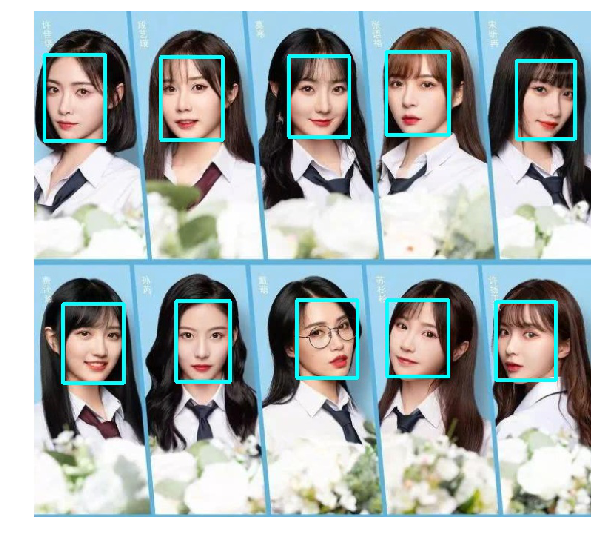

In [5]:
detect_show(module, ['images/youngni2.jpg'], 'images/output')

[2020-04-25 08:55:53,574] [    INFO] - Installing pyramidbox_face_detection module


[==================================================] 100.00%
Uncompress /home/aistudio/.paddlehub/tmp/tmp4mfyx6z3/pyramidbox_face_detection
[==================================================] 100.00%


[2020-04-25 08:56:05,794] [    INFO] - Successfully installed pyramidbox_face_detection-1.0.0
[2020-04-25 08:56:06,309] [    INFO] - 260 pretrained paramaters loaded by PaddleHub


The image with bbox is saved as ./output/young2.jpg


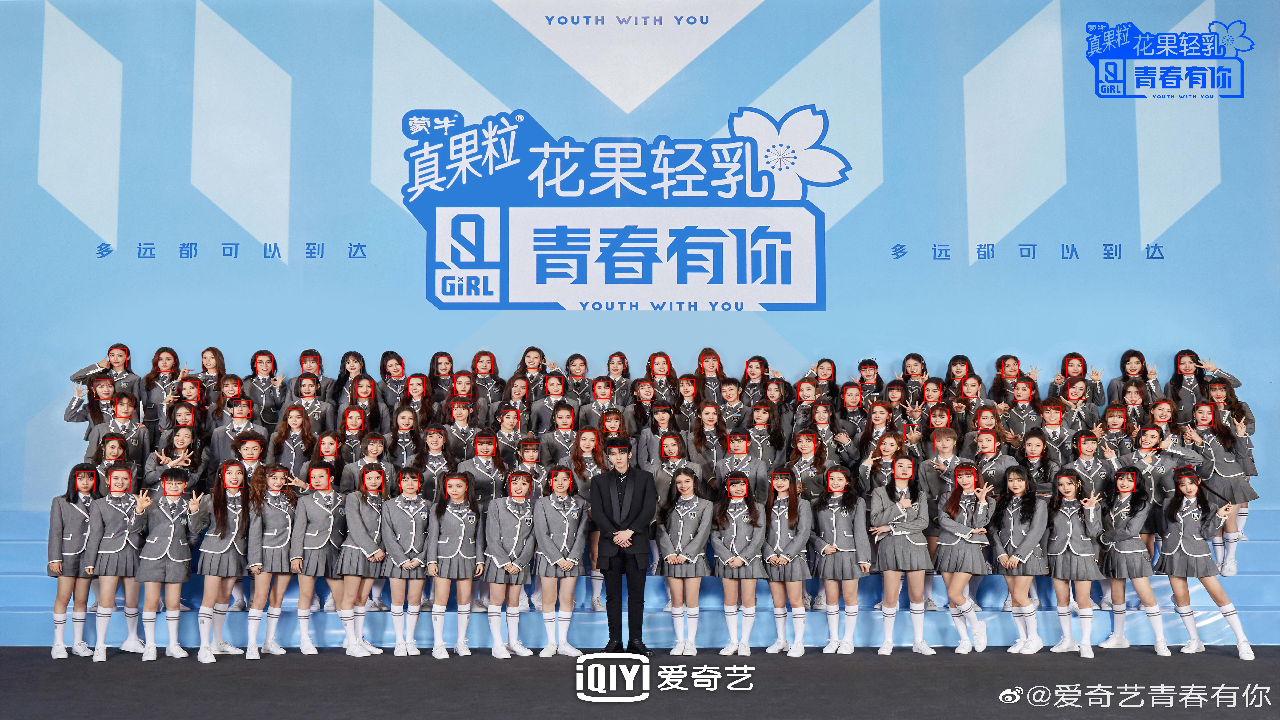

In [6]:

# 使用复杂一点的模型对大合照进行检测
module_pyramidbox = hub.Module(name="pyramidbox_face_detection")
input_dict = {"image": ['images/young2.jpg']}
results = module_pyramidbox.face_detection(data=input_dict) 
display(Image.open('./output/young2.jpg').resize((1280, 720)))

## 2. 人脸关键点检测
### 2.1 利用paddlehub face_landmark_localization模型进行关键点检测

[2020-04-25 08:56:45,281] [    INFO] - Installing face_landmark_localization module
[2020-04-25 08:56:45,297] [    INFO] - Module face_landmark_localization already installed in /home/aistudio/.paddlehub/modules/face_landmark_localization
[2020-04-25 08:56:45,299] [    INFO] - Installing ultra_light_fast_generic_face_detector_1mb_640 module
[2020-04-25 08:56:45,314] [    INFO] - Module ultra_light_fast_generic_face_detector_1mb_640 already installed in /home/aistudio/.paddlehub/modules/ultra_light_fast_generic_face_detector_1mb_640


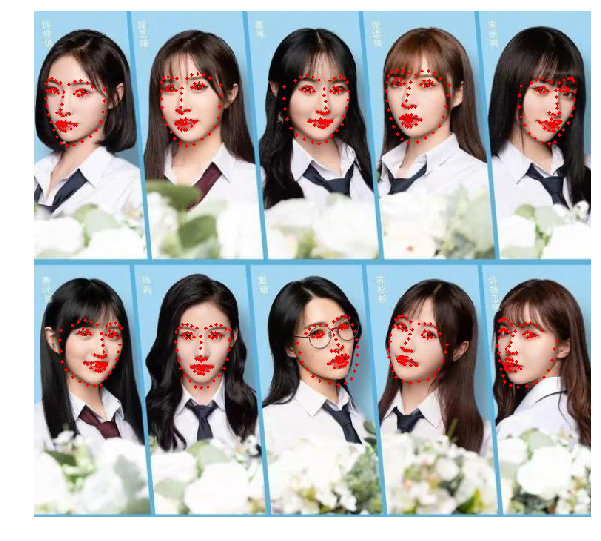

In [7]:
import cv2
import paddlehub as hub
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import numpy as np
import math
%matplotlib inline

src_img = cv2.imread('images/youngni2.jpg')

module = hub.Module(name="face_landmark_localization")
result = module.keypoint_detection(images=[src_img])

tmp_img = src_img.copy()
for face in result[0]['data']:
	for index, point in enumerate(face):
		# print(point)
		# cv2.putText(img, str(index), (int(point[0]), int(point[1])), cv2.FONT_HERSHEY_COMPLEX, 3, (0,0,255), -1)
		cv2.circle(tmp_img, (int(point[0]), int(point[1])), 2, (0, 0, 255), -1)

res_img_path = 'face_landmark.jpg'
cv2.imwrite(res_img_path, tmp_img)

img = mpimg.imread(res_img_path) 
# 展示预测68个关键点结果
plt.figure(figsize=(10,10))
plt.imshow(img) 
plt.axis('off') 
plt.show()

### 2.2 猫脸人嘴特效
通过人脸关键点检测+猫脸检测模型（没有找到猫脸关键点检测模型），结合泊松融合将人嘴替换到猫脸上，实现抖音猫脸人嘴特效

In [ ]:
import cv2
import numpy as np
import paddlehub as hub

# 人脸关键点检测器
module = hub.Module(name="face_landmark_localization")
# 猫脸检测器
cat_path = "haarcascade_frontalcatface_extended.xml"
facecascade = cv2.CascadeClassifier(cat_path)
ret = facecascade.load(cat_path) 
old_cat_face_loc = np.array([-1,-1])

# 猫脸检测
def human_mouth_paste_to_cat(human_frame, cat_frame):
    global old_cat_face_loc 
    result = module.keypoint_detection(images=[human_frame])
    landmarks = result[0]['data'][0]
    landmarks = np.array(landmarks, dtype=np.int)

    mouth_landmark = landmarks[48:,:]
    # 扩个边
    border = 8
    mouth = human_frame[int(np.min(mouth_landmark[:,1])) - border : int(np.max(mouth_landmark[:,1]) + border), int(np.min(mouth_landmark[:,0])) - border : int(np.max(mouth_landmark[:,0])) + border, :]
    mouth_landmark[:,0] -= (np.min(mouth_landmark[:,0]) - border)
    mouth_landmark[:,1] -= (np.min(mouth_landmark[:,1]) - border)

    # 制作用于泊松融合的mask
    mask=np.zeros((mouth.shape[0],mouth.shape[1],3)).astype(np.float32)
    for i in range(mouth_landmark.shape[0]): #先画线
        cv2.line(mask,(mouth_landmark[i,0], mouth_landmark[i,1]), (mouth_landmark[(i+1)%mouth_landmark.shape[0],0],mouth_landmark[(i+1)%mouth_landmark.shape[0],1]),(255,255,255),10)
    mask_tmp=mask.copy()
    for i in range(6,mask.shape[0]-6):#将线内部的范围都算作mask=255
        for j in range(6,mask.shape[1]-6):
            if(np.max(mask_tmp[:i,:j,:])==0 or np.max(mask_tmp[i:,:j,:])==0 or np.max(mask_tmp[:i,j:,:])==0 or np.max(mask_tmp[i:,j:,:])==0):
                mask[i,j,:]=0
            else:
                mask[i,j,:]=255
    
    # 猫脸检测
    width, height, channels = cat_frame.shape
    cat_gray = cv2.cvtColor(cat_frame, cv2.COLOR_BGR2GRAY)
    cat_face_loc= facecascade.detectMultiScale(cat_gray,scaleFactor = 1.1,minNeighbors=3,minSize=(100,100),flags=cv2.CASCADE_SCALE_IMAGE)
    cat_face_loc = np.array(cat_face_loc)
    if len(cat_face_loc) == 0:
        return cat_frame
    ind = np.argmin(cat_face_loc[:, 1])
    cat_face_loc = cat_face_loc[ind]
    if(old_cat_face_loc[0] != -1): # 因为猫脸检测抖动太厉害，所以此处用历史坐标缓冲一下
        cat_face_loc = 0.9*old_cat_face_loc + 0.1*cat_face_loc
    old_cat_face_loc = cat_face_loc
    center = (int(cat_face_loc[0]+cat_face_loc[2]/2), int(cat_face_loc[1]+cat_face_loc[3]*0.8))#0.8为手动设定的猫嘴位置，因为没找到猫脸landmark

    normal_clone = cv2.seamlessClone(mouth, cat_frame, mask.astype(mouth.dtype), center, cv2.NORMAL_CLONE)
    #mixed_clone = cv2.seamlessClone(mouth, cat, mask.astype(mouth.dtype), center, cv2.MIXED_CLONE)
    #cv2.imwrite("opencv-normal-clone-example.jpg", normal_clone)
    #cv2.imwrite("opencv-mixed-clone-example.jpg", mixed_clone)
    return normal_clone

# human = cv2.imread('huaman2.png') 
# cat = cv2.imread('cat.png') 
# cat_with_human_mouth = human_mouth_paste_to_cat(human, cat)
# cv2.imwrite("opencv-mixed-clone-example.jpg", cat_with_human_mouth)
human_video_cap = cv2.VideoCapture("human.mp4")
cat_video_cap =cv2.VideoCapture("cat1.mp4")

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #cv2.VideoWriter_fourcc(*'MJPG')
video_writer = cv2.VideoWriter('cat_with_humanmouth.MP4', fourcc, 25, (544,960))

index=0
while(True):
    index+=1
    if(index>900):
        break
    human_ret, human_frame = human_video_cap.read()
    human_frame = cv2.resize(human_frame,dsize=None,fx=2,fy=2)
    cat_ret, cat_frame = cat_video_cap.read()
    if(human_ret == True and cat_ret == True):
        cat_with_human_mouth = human_mouth_paste_to_cat(human_frame, cat_frame)
        video_writer.write(cat_with_human_mouth.astype(np.uint8))
        # cv2.imwrite("frame/%d.jpg" % index, cat_with_human_mouth)

video_writer.release()
# 视频结果见介绍

* 视频猫脸抖动导致检测效果不好，这里用一张静态猫片试一下

In [22]:
import numpy as np

cat_path = "haarcascade_frontalcatface_extended.xml"
facecascade = cv2.CascadeClassifier(cat_path)
# 人脸关键点检测器
module = hub.Module(name="face_landmark_localization")
# 猫脸检测器

cat = cv2.imread('cat3.jpg') 

cat_gray = cv2.cvtColor(cat, cv2.COLOR_BGR2GRAY)
cat_face_loc= facecascade.detectMultiScale(cat_gray,scaleFactor = 1.1,minNeighbors=3,minSize=(100,100),flags=cv2.CASCADE_SCALE_IMAGE)
cat_face_loc = np.array(cat_face_loc[0])
# 猫嘴中心位置
center = (int(cat_face_loc[0] + cat_face_loc[2] / 2), int(cat_face_loc[1] + cat_face_loc[3]*0.8))

def human_mouth_paste_to_cat(human_frame, cat_frame):
    global old_cat_face_loc 
    result = module.keypoint_detection(images=[human_frame])
    landmarks = result[0]['data'][0]
    landmarks = np.array(landmarks, dtype=np.int)

    mouth_landmark = landmarks[48:,:]
    # 扩个边
    border = 8
    mouth = human_frame[int(np.min(mouth_landmark[:,1])) - border : int(np.max(mouth_landmark[:,1]) + border), int(np.min(mouth_landmark[:,0])) - border : int(np.max(mouth_landmark[:,0])) + border, :]
    mouth_landmark[:,0] -= (np.min(mouth_landmark[:,0]) - border)
    mouth_landmark[:,1] -= (np.min(mouth_landmark[:,1]) - border)

    # 制作用于泊松融合的mask
    mask=np.zeros((mouth.shape[0],mouth.shape[1],3)).astype(np.float32)
    for i in range(mouth_landmark.shape[0]): #先画线
        cv2.line(mask,(mouth_landmark[i,0], mouth_landmark[i,1]), (mouth_landmark[(i+1)%mouth_landmark.shape[0],0],mouth_landmark[(i+1)%mouth_landmark.shape[0],1]),(255,255,255),10)
    mask_tmp=mask.copy()
    for i in range(6,mask.shape[0]-6):#将线内部的范围都算作mask=255
        for j in range(6,mask.shape[1]-6):
            if(np.max(mask_tmp[:i,:j,:])==0 or np.max(mask_tmp[i:,:j,:])==0 or np.max(mask_tmp[:i,j:,:])==0 or np.max(mask_tmp[i:,j:,:])==0):
                mask[i,j,:]=0
            else:
                mask[i,j,:]=255
    
    normal_clone = cv2.seamlessClone(mouth, cat_frame, mask.astype(mouth.dtype), center, cv2.NORMAL_CLONE)

    return normal_clone


# human = cv2.imread('huaman2.png') 
# cat_with_human_mouth = human_mouth_paste_to_cat(human, cat)
# cv2.imwrite("opencv-mixed-clone-example.jpg", cat_with_human_mouth)

# 合成视频
human_video_cap = cv2.VideoCapture("human2.mp4") 

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')  
video_writer = cv2.VideoWriter('cat_with_humanmouth2.MP4', fourcc, 25, (1080,2340))

index=0
while(True):
    index+=1
    # if(index>200):
        # break
    human_ret, human_frame = human_video_cap.read()

    if human_ret:        
        human_frame = cv2.resize(human_frame,dsize=None,fx=2,fy=2)
        cat_with_human_mouth = human_mouth_paste_to_cat(human_frame, cat)
        video_writer.write(cat_with_human_mouth.astype(np.uint8))
        # cv2.imwrite("frame/%d.jpg" % index, cat_with_human_mouth)
    else:
        break

video_writer.release()

# print(cat_face_loc)
# cv2.rectangle(cat, (cat_face_loc[0], cat_face_loc[1]), (cat_face_loc[0] + cat_face_loc[2], cat_face_loc[1] + cat_face_loc[3]), (0, 255, 0), 2, 8)
# cv2.circle(cat, center, 2,  (0, 0, 255), 3)

# image = Image.fromarray(cv2.cvtColor(cat_with_human_mouth, cv2.COLOR_BGR2RGB))  
# display(image)

[2020-04-25 00:05:54,174] [    INFO] - Installing face_landmark_localization module
[2020-04-25 00:05:54,206] [    INFO] - Module face_landmark_localization already installed in /home/aistudio/.paddlehub/modules/face_landmark_localization
[2020-04-25 00:05:54,207] [    INFO] - Installing ultra_light_fast_generic_face_detector_1mb_640 module
[2020-04-25 00:05:54,229] [    INFO] - Module ultra_light_fast_generic_face_detector_1mb_640 already installed in /home/aistudio/.paddlehub/modules/ultra_light_fast_generic_face_detector_1mb_640


## 3. 头部姿态估计 + 川剧变脸
本部分根据官方提供的变脸案列实现，通过头部姿态估计可以识别头部是否有发生点头、摇头、眨眼、张嘴的动作。这些动作可以根据face_landmark_localization预测人脸关键点位置计算头部的[欧拉角](https://baike.baidu.com/item/%E6%AC%A7%E6%8B%89%E8%A7%92/1626212?fr=aladdin)，进而实现动作判断。  

<br>
当动作判断为摇头时，立即更换张贴在人脸上的脸谱。
<br>  
  
![avatar](https://pic4.zhimg.com/50/v2-35da80e428ca5750491ffd2770e187e1_hd.webp)

### 3.1 头部姿态识别

In [11]:
import cv2
import numpy as np
import paddlehub as hub
from paddlehub.common.logger import logger
import time
import math
import os

# 人脸检测器，为了检测画面中人脸位置，将人脸替换成脸谱
face_detector = hub.Module(name="ultra_light_fast_generic_face_detector_1mb_640")

class HeadPostEstimation(object):
    """
        头部姿态识别
    """
    NOD_ACTION = 1
    SHAKE_ACTION = 2
    def __init__(self, face_detector=None):
        self.module = hub.Module(name="face_landmark_localization", face_detector_module=face_detector)
        # 头部3D关键点坐标
        self.model_points = np.array([
                                      [6.825897, 6.760612, 4.402142],
                                      [1.330353, 7.122144, 6.903745],
                                      [-1.330353, 7.122144, 6.903745],
                                      [-6.825897, 6.760612, 4.402142],
                                      [5.311432, 5.485328, 3.987654],
                                      [1.789930, 5.393625, 4.413414],
                                      [-1.789930, 5.393625, 4.413414],
                                      [-5.311432, 5.485328, 3.987654],
                                      [2.005628, 1.409845, 6.165652],
                                      [-2.005628, 1.409845, 6.165652],
                                      [2.774015, -2.080775, 5.048531],
                                      [-2.774015, -2.080775, 5.048531],
                                      [0.000000, -3.116408, 6.097667],
                                      [0.000000, -7.415691, 4.070434],
                                      [-7.308957, 0.913869, 0.000000],
                                      [7.308957, 0.913869, 0.000000],
                                      [0.746313,0.348381,6.263227],
                                      [0.000000,0.000000,6.763430],
                                      [-0.746313,0.348381,6.263227],
                                      ], dtype='float')
            
        # 点头动作index是0， 摇头动作index是1
        # 当连续30帧上下点头动作幅度超过5度时，认为发生了点头动作
        # 当连续30帧上下点头动作幅度超过30度时，认为发生了摇头动作，由于摇头动作较为敏感，故所需幅度更大
        self._index_action = {0:'nod', 1:'shake'}
        self._frame_window_size = 15
        self._pose_threshold = {0: 5/180 * math.pi,
          1: 15/180 * math.pi}
        # 头部3D投影点
        self.reprojectsrc = np.float32([
                                      [10.0, 10.0, 10.0],
                                      [10.0, 10.0, -10.0],
                                      [10.0, -10.0, -10.0],
                                      [10.0, -10.0, 10.0],
                                      [-10.0, 10.0, 10.0],
                                      [-10.0, 10.0, -10.0],
                                      [-10.0, -10.0, -10.0],
                                      [-10.0, -10.0, 10.0]])
        # 头部3D投影点连线
        self.line_pairs = [
                         [0, 1], [1, 2], [2, 3], [3, 0],
                         [4, 5], [5, 6], [6, 7], [7, 4],
                         [0, 4], [1, 5], [2, 6], [3, 7]
                         ]

        self.masks = [
            cv2.imread('mask_1.png', -1),
            cv2.imread('mask_2.png', -1),
            cv2.imread('mask_3.png', -1),
            cv2.imread('mask_4.png', -1)
        ]
        self.index = 0

    @property
    def frame_window_size(self):
        return self._frame_window_size
    
    @frame_window_size.setter
    def frame_window_size(self, value):
        assert isinstance(value, int)
        self._frame_window_size = value
    
    @property
    def pose_threshold(self):
        return self._pose_threshold
    
    @pose_threshold.setter
    def pose_threshold(self, dict_value):
        assert list(dict_value.keys()) == [0,1,2]
        self._pose_threshold = dict_value
    
    def get_face_landmark(self, image):
        """
        预测人脸的68个关键点坐标
        images(ndarray): 单张图片的像素数据
        """
        try:
            # 选择GPU运行，use_gpu=True，并且在运行整个教程代码之前设置CUDA_VISIBLE_DEVICES环境变量
            res = self.module.keypoint_detection(images=[image], use_gpu=False)
            return True, res[0]['data'][0]
        except Exception as e:
            logger.error("Get face landmark localization failed! Exception: %s " % e)
            return False, None

    def get_image_points_from_landmark(self, face_landmark):
        """
        从face_landmark_localization的检测结果抽取姿态估计需要的点坐标
        """
        image_points = np.array([
                                 face_landmark[17], face_landmark[21],
                                 face_landmark[22], face_landmark[26],
                                 face_landmark[36], face_landmark[39],
                                 face_landmark[42], face_landmark[45],
                                 face_landmark[31], face_landmark[35],
                                 face_landmark[48], face_landmark[54],
                                 face_landmark[57], face_landmark[8],
                                 face_landmark[14], face_landmark[2],
                                 face_landmark[32], face_landmark[33],
                                 face_landmark[34],
                                 ], dtype='float')
        return image_points
        
    def caculate_pose_vector(self, image_points):
        """
        获取旋转向量和平移向量
        """
        # 相机视角
        center = (self.img_size[1]/2, self.img_size[0]/2)
        focal_length = center[0] / np.tan(60/ 2 * np.pi / 180)
        camera_matrix = np.array([
                                  [focal_length, 0, center[0]],
                                  [0, focal_length, center[1]],
                                  [0, 0, 1]],
                                 dtype = "float")
                                 # 假设没有畸变
        dist_coeffs = np.zeros((4,1))
                                 
        success, rotation_vector, translation_vector= cv2.solvePnP(self.model_points,
                                                                image_points,
                                                                camera_matrix,
                                                                dist_coeffs)

        reprojectdst, _ = cv2.projectPoints(self.reprojectsrc, rotation_vector, translation_vector, camera_matrix, dist_coeffs)
                         
        return success, rotation_vector, translation_vector, camera_matrix, dist_coeffs, reprojectdst

    def caculate_euler_angle(self, rotation_vector, translation_vector):
        """
        将旋转向量转换为欧拉角
        """
        rvec_matrix = cv2.Rodrigues(rotation_vector)[0]
        proj_matrix = np.hstack((rvec_matrix, translation_vector))
        euler_angles = cv2.decomposeProjectionMatrix(proj_matrix)[6]
        pitch, yaw, roll = [math.radians(_) for _ in euler_angles]
        return pitch, yaw, roll

        
    def classify_pose_in_euler_angles(self, video, poses=3):
        """
        根据欧拉角分类头部姿态(点头nod/摇头shake)
        video 表示不断产生图片的生成器
        pose=1 表示识别点头动作
        pose=2 表示识别摇头动作
        pose=3 表示识别点头和摇头动作
        """
        frames_euler = []
        index_action ={0:[self.NOD_ACTION], 1:[self.SHAKE_ACTION]}
        
        for index, img in enumerate(video(), start=1):
            self.img_size = img.shape
            
            success, face_landmark = self.get_face_landmark(img)
            
            for i, action in enumerate(index_action):
                if i == 0:
                    index_action[action].append((20, int(self.img_size[0]/2 + 110)))
                elif i == 1:
                    index_action[action].append((120, int(self.img_size[0]/2 + 110)))
        
            if not success:
                logger.info("Get face landmark localization failed! Please check your image!")
                continue

            image_points = self.get_image_points_from_landmark(face_landmark)
            success, rotation_vector, translation_vector, camera_matrix, dist_coeffs, reprojectdst = self.caculate_pose_vector(image_points)

            if not success:
                logger.info("Get rotation and translation vectors failed!")
                continue
        
            # 计算头部欧拉角
            pitch, yaw, roll = self.caculate_euler_angle(rotation_vector, translation_vector)
            frames_euler.append([index, img, pitch, yaw, roll])

            # 转换成摄像头可显示的格式
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if len(frames_euler) > self.frame_window_size:
                # 比较当前头部动作欧拉角与过去的欧拉角，只有动作幅度幅度超过阈值，则判定发生相应的动作
                # picth值用来判断点头动作
                # yaw值用来判断摇头动作
                current = [pitch, yaw, roll]
                tmp = [abs(pitch), abs(yaw)]
                max_index = tmp.index(max(tmp))
                max_probability_action = index_action[max_index][0]
                for start_idx, start_img, p, y, r in frames_euler[0:int(self.frame_window_size/2)]:
                    start = [p, y, r]
                    if poses & max_probability_action and abs(start[max_index]-current[max_index]) >= self.pose_threshold[max_index]:
                        frames_euler = []
                        # 摇头发生时即可更换脸谱
                        if self._index_action[max_index] == 'shake':
                          self.index += 1
                          self.index %= 4

                        yield {self._index_action[max_index]: [(start_idx, start_img), (index, img)]}
                        break
                else:
                    # 丢弃过时的视频帧
                    frames_euler.pop(0)

            # 检测画面中人脸位置
            
            result = face_detector.face_detection(images=[img])
            if result[0]['data']:
                rect_left = int(result[0]['data'][0]['left'])
                rect_right = int(result[0]['data'][0]['right'])
                rect_bottom = int(result[0]['data'][0]['bottom'])
                rect_top = int(result[0]['data'][0]['top'])
                mask = cv2.resize(self.masks[self.index], (rect_right - rect_left, rect_bottom - rect_top))
                index = mask[:,:,3] != 0
                index = np.repeat(index[:,:,np.newaxis], axis=2, repeats=3)
                img_rgb[rect_top:rect_bottom, rect_left:rect_right,:][index] = mask[:,:,:3][index]
            
            # 本地显示预测视频框，AIStudio项目不支持显示视频框
            # cv2.imshow('Face', img_rgb)
            # 写入预测结果
            video_writer.write(img_rgb)

[2020-04-25 09:14:13,997] [    INFO] - Installing ultra_light_fast_generic_face_detector_1mb_640 module
[2020-04-25 09:14:14,015] [    INFO] - Module ultra_light_fast_generic_face_detector_1mb_640 already installed in /home/aistudio/.paddlehub/modules/ultra_light_fast_generic_face_detector_1mb_640


### 3.1 定义预测输出函数
**NOTE: 由于AIStudio项目不支持打开视频格式文件，需要大家将运行结果result.mp4下载到本地，进行观看最终结果。**

In [ ]:
# 打开摄像头
# capture  = cv2.VideoCapture(0) 
capture  = cv2.VideoCapture('test_sample.mov')
fps = capture.get(cv2.CAP_PROP_FPS)
size = (int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)),
        int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
# 将预测结果写成视频
video_writer = cv2.VideoWriter('result.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, size)

def generate_image():
    while True:
        # frame_rgb即视频的一帧数据
        ret, frame_rgb = capture.read() 
        # 按q键即可退出
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        if frame_rgb is None:
            break
        frame_bgr = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR)
        yield frame_bgr
    capture.release()
    video_writer.release()
    cv2.destroyAllWindows()

想要体验下效果如何，可以将本教程中代码拷贝复制到配有摄像头的电脑上，同时改为从摄像头获取画面

`cv2.VideoCapture(0)`



### 3.2 预测视频流中发生的动作

根据以上代码，只需调用HeadPoseEstimation的classify_pose_in_euler_angles接口即可实现预测视频中是否发生点头、摇头等动作，实现活体检测。

通过头部姿态估计识别视频中是否发生点头、摇头等动作，并在摇头动作发生时更换脸谱。

**NOTE: 由于AIStudio项目不支持打开视频格式文件，大家将运行结果result.mp4下载到本地，进行观看最终结果。**

In [ ]:
head_post = HeadPostEstimation()
# 发生摇头时，实现AI川剧变脸
for res in head_post.classify_pose_in_euler_angles(video=generate_image, poses=HeadPostEstimation.SHAKE_ACTION):
    print("Change Mask, AI Sichuan Opera!")

TypeError: __new__() got an unexpected keyword argument 'face_detector_module'

**如果想要实时显示预测结果，可以下载AI_Sichuan_Opera.py脚本以及4张脸谱图片（mask_1.png、mask_2.png、mask_3.png、mask_4.png）至本地，并存放在同一路径下。在该路径下运行脚本即可。**

**运行代码示例时，请调整摄像头的位置，使得正位时的人脸可以正对摄像头。**

### 3.3 进一步优化效果

为了稳定视频流中的人脸位置，得到更优的预测效果。我们基于face_landmark_localization默认使用的人脸检测器ultra_light_fast_generic_face_detector_1mb_640进行人脸检测，并对多帧之间的人脸框进行加权平均，从而提升稳定性。

**NOTE: 由于AIStudio项目不支持打开视频格式文件，大家将运行结果result_enhancement.mp4下载到本地，进行观看最终结果。**

**如果想要实时显示预测结果，可以下载AI_Sichuan_Opera_enhancement.py脚本以及4张脸谱图片（mask_1.png、mask_2.png、mask_3.png、mask_4.png）至本地，并存放在同一路径下。在该路径下运行脚本即可。**

**运行代码示例时，请调整摄像头的位置，使得正位时的人脸可以正对摄像头。**

In [12]:
class MyFaceDetector(object):
    """
    自定义人脸检测器
    基于PaddleHub人脸检测模型ultra_light_fast_generic_face_detector_1mb_640，加强稳定人脸检测框
    """
    def __init__(self):
        self.module = hub.Module(name="ultra_light_fast_generic_face_detector_1mb_640")
        self.alpha = 0.75
        self.start_flag =1

    def face_detection(self,images, use_gpu=False, visualization=False):
        # 使用GPU运行，use_gpu=True，并且在运行整个教程代码之前设置CUDA_VISIBLE_DEVICES环境变量
        result = self.module.face_detection(images=images, use_gpu=use_gpu, visualization=visualization)
        if not result[0]['data']:
            return result

        face = result[0]['data'][0]
        if self.start_flag == 1:

            self.left_s = result[0]['data'][0]['left']
            self.right_s = result[0]['data'][0]['right']
            self.top_s = result[0]['data'][0]['top']
            self.bottom_s = result[0]['data'][0]['bottom']

            self.start_flag=0
        else:
            # 加权平均上一帧和当前帧人脸检测框位置，以稳定人脸检测框
            self.left_s = self.alpha * self.left_s +  (1-self.alpha) * face['left'] 
            self.right_s = self.alpha * self.right_s +  (1-self.alpha) * face['right'] 
            self.top_s = self.alpha * self.top_s +  (1-self.alpha) * face['top']
            self.bottom_s = self.alpha * self.bottom_s + (1-self.alpha) * face['bottom'] 

        result[0]['data'][0]['left'] = self.left_s
        result[0]['data'][0]['right'] = self.right_s
        result[0]['data'][0]['top'] = self.top_s
        result[0]['data'][0]['bottom'] = self.bottom_s

        return result

# 定义人脸检测器
face_detector = MyFaceDetector()

# 打开摄像头
# capture  = cv2.VideoCapture(0) 
capture  = cv2.VideoCapture('./test_sample.mov')
fps = capture.get(cv2.CAP_PROP_FPS)
size = (int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)),
        int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
# 将预测结果写成视频
video_writer = cv2.VideoWriter('result_enhancement.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, size)

def generate_image():
    while True:
        # frame_rgb即视频的一帧数据
        ret, frame_rgb = capture.read() 
        # 按q键即可退出
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        if frame_rgb is None:
            break
        frame_bgr = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR)
        yield frame_bgr
    capture.release()
    video_writer.release()
    cv2.destroyAllWindows()

head_post = HeadPostEstimation(face_detector)
# 发生摇头时，实现AI川剧变脸
for res in head_post.classify_pose_in_euler_angles(video=generate_image, poses=HeadPostEstimation.SHAKE_ACTION):
    print("Change Mask, AI Sichuan Opera!")